# 🤖 Credit Score Simulator – Modeling & Evaluation

## 1. Objective

This notebook focuses on building and evaluating machine learning models to predict whether a customer will experience **serious delinquency** (90+ days overdue) within the next two years.

The main objectives are to:

- Train and compare baseline classification models
- Address class imbalance in the target variable
- Perform hyperparameter tuning to improve performance
- Evaluate models using precision, recall, F1-score, and AUC
- Select and export the best model for deployment

All preprocessing and feature engineering steps were completed in the previous notebook to prevent data leakage.  
At the end of this notebook, the final trained model and decision threshold will be exported for use in the **credit score simulator app**.


In [38]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import optuna
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", message="X does not have valid feature names")


## 2. Load Dataset 📂

The dataset `df_cleaned.csv` includes:

- Selected original features  
- Engineered variables created based on domain logic  
- **Unscaled numeric values** to allow flexible preprocessing during model training  
- The target variable: `SeriousDlqin2yrs` (0 = No Default, 1 = Default)


In [39]:
# Load the cleaned dataset
df = pd.read_csv("../data/df_cleaned.csv")  # Ajusta ruta si es necesario

# Preview
df.head()


,SeriousDlqin2yrs,RevolvingUtilization,age,Times30_59DaysLate,DebtToIncomeRatio,OpenCreditLines,Times90DaysLate,RealEstateLoans,Times60_89DaysLate,MonthlyIncome,NumberOfDependents,TotalPastDue,FinancialStressScore,CreditBurdenPerLine,AgeUtilizationRatio,IncomeAgeRatio,LinesPerYear
0,1,0.766127,45,2,0.802982,13,0,6,0,9120.0,2.0,2,0.615186,651.428571,57.980231,198.260870,0.282609
1,0,0.957151,40,0,0.121876,4,0,0,0,2600.0,1.0,0,0.116654,520.000000,41.358587,63.414634,0.097561
2,0,0.658180,38,1,0.085113,2,1,0,0,3042.0,0.0,2,0.056020,1014.000000,56.870891,78.000000,0.051282
3,0,0.233810,30,0,0.036050,5,0,0,0,3300.0,0.0,0,0.008429,550.000000,123.046748,106.451613,0.161290
4,0,0.907239,49,1,0.024926,7,0,1,0,23011.9,0.0,1,0.022614,2876.487500,53.421168,460.238000,0.140000


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147610 entries, 0 to 147609
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   SeriousDlqin2yrs      147610 non-null  int64  
 1   RevolvingUtilization  147610 non-null  float64
 2   age                   147610 non-null  int64  
 3   Times30_59DaysLate    147610 non-null  int64  
 4   DebtToIncomeRatio     147610 non-null  float64
 5   OpenCreditLines       147610 non-null  int64  
 6   Times90DaysLate       147610 non-null  int64  
 7   RealEstateLoans       147610 non-null  int64  
 8   Times60_89DaysLate    147610 non-null  int64  
 9   MonthlyIncome         147610 non-null  float64
 10  NumberOfDependents    147610 non-null  float64
 11  TotalPastDue          147610 non-null  int64  
 12  FinancialStressScore  147610 non-null  float64
 13  CreditBurdenPerLine   147610 non-null  float64
 14  AgeUtilizationRatio   147610 non-null  float64
 15  

In [41]:
df['SeriousDlqin2yrs'].value_counts(normalize=True)

SeriousDlqin2yrs
0    0.93327
1    0.06673
Name: proportion, dtype: float64

## 3. Train/Validation/Test Split 📊

To ensure reliable model evaluation and avoid data leakage, the dataset is split into two subsets:

- **Training set (80%)** – Used to train and validate the model  
- **Test set (20%)** – Held out for final evaluation to assess generalization on unseen data

The split was performed using `train_test_split` with **stratification**, to preserve the proportion of the target variable (`SeriousDlqin2yrs`) across both sets.


In [42]:
X = df.drop(columns="SeriousDlqin2yrs")
y = df["SeriousDlqin2yrs"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train:      {X_train.shape}")
print(f"Test:       {X_test.shape}")


Train:      (118088, 16)
Test:       (29522, 16)


## 4. Model Selection and Comparison 🧠

To compare the performance of several baseline models, a consistent training and evaluation approach was used. This ensured that all models were assessed under the same conditions, allowing for a fair and reliable comparison.

- **Models trained:** Logistic Regression, Random Forest, XGBoost, and LightGBM  
- **Validation strategy:** 10-Fold Stratified Cross-Validation to preserve class distribution across folds  
- **Preprocessing within each fold:**  
  - Feature scaling to normalize input variables  
  - Class balancing using SMOTE to address target imbalance  
- **Evaluation metrics:**  
  - AUC (Area Under the ROC Curve)  
  - F1-score  
  - Precision  
  - Recall  
- **Performance recording:** Mean metric values were calculated across the 10 folds  
- **Purpose:** To ensure a standardized and fair comparison across all candidate models


In [58]:
# Define models with basic hyperparameters 
models = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1),
}

# Initialize cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# To store results
results = []

# Evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}")
    aucs, f1s, precisions, recalls = [], [], [], []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold_raw, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_fold_raw, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]

        # Scale training and validation separately to avoid leakage
        scaler = MinMaxScaler()
        X_train_fold_scaled = scaler.fit_transform(X_train_fold_raw)
        X_val_fold_scaled = scaler.transform(X_val_fold_raw)

        # Apply SMOTE on the scaled training fold
        smote = SMOTE(random_state=42)
        X_train_fold, y_train_fold = smote.fit_resample(X_train_fold_scaled, y_train_fold)

        # Fit model and evaluate
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold_scaled)
        y_prob = model.predict_proba(X_val_fold_scaled)[:, 1]

        aucs.append(roc_auc_score(y_val_fold, y_prob))
        f1s.append(f1_score(y_val_fold, y_pred))
        precisions.append(precision_score(y_val_fold, y_pred))
        recalls.append(recall_score(y_val_fold, y_pred))

    # Store average CV metrics + test metrics
    results.append({
        'Model': model_name,
        'CV AUC': np.mean(aucs),
        'CV AUC std': np.std(aucs),
        'CV F1': np.mean(f1s),
        'CV F1 std': np.std(f1s),
        'CV Precision': np.mean(precisions),
        'CV Recall': np.mean(recalls),
    })

# Show results
results_df = pd.DataFrame(results)
results_df


Training LogisticRegression
Training RandomForest
Training XGBoost
Training LightGBM


,Model,CV AUC,CV AUC std,CV F1,CV F1 std,CV Precision,CV Recall
0,LogisticRegression,0.853684,0.006450,0.331085,0.005399,0.212557,0.748604
1,RandomForest,0.831427,0.007121,0.344086,0.019846,0.417113,0.293020
2,XGBoost,0.844814,0.007556,0.326668,0.020823,0.461731,0.252919
3,LightGBM,0.855722,0.007671,0.366105,0.018174,0.481172,0.295558


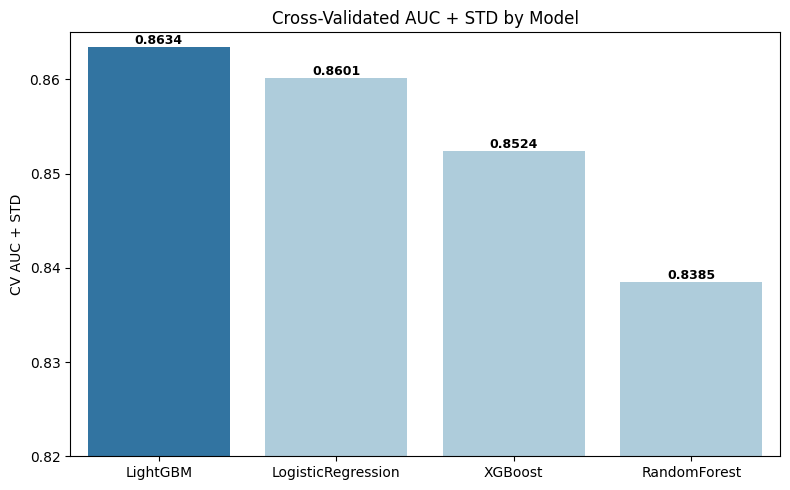

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular AUC + STD
results_df['AUC + STD'] = results_df['CV AUC'] + results_df['CV AUC std']

# Ordenar por AUC + STD
results_sorted = results_df.sort_values(by='AUC + STD', ascending=False)

# Colores personalizados: azul más oscuro para el ganador
colors = ['#1f77b4' if model == 'LightGBM' else '#a6cee3' for model in results_sorted['Model']]

# Crear gráfico
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Model', y='AUC + STD', data=results_sorted, hue='Model', palette=colors, legend=False)
plt.title('Cross-Validated AUC + STD by Model')
plt.ylabel('CV AUC + STD')
plt.xlabel('')
plt.ylim(0.82, 0.865)

# Añadir los valores sobre las barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.4f}', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()



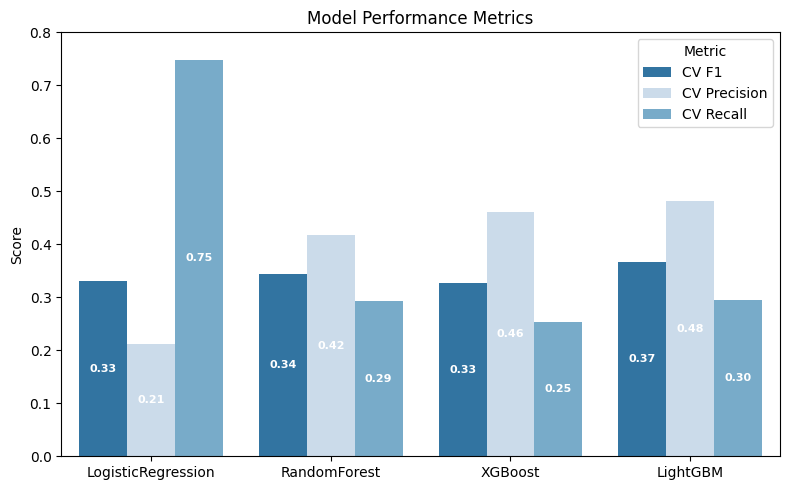

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reestructurar el DataFrame
df_melted = results_df.melt(id_vars='Model',
                            value_vars=['CV F1', 'CV Precision', 'CV Recall'],
                            var_name='Metric', value_name='Score')

# Colores personalizados (F1 más oscuro)
palette_custom = {
    'CV F1': '#1f77b4',         
    'CV Precision': '#c6dbef',  
    'CV Recall': '#6baed6'     
}

# Gráfico
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Model', y='Score', hue='Metric', data=df_melted, palette=palette_custom)
plt.title('Model Performance Metrics')
plt.ylim(0, 0.8)
plt.ylabel('Score')
plt.xlabel('')

# Etiquetas dentro de las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=8, color='white', weight='bold')

plt.legend(title='Metric')
plt.tight_layout()
plt.show()


## 5. Hyperparameter Tuning ⚙️

To improve the performance of the best baseline model, hyperparameter tuning was conducted using Optuna.

- **Model optimized:** LightGBM, identified as the top performer based on CV AUC and F1 score  
- **Optimization method:** Optuna, a powerful hyperparameter optimization framework  
- **Objective:** Maximize average AUC score across 10 Stratified K-Folds  
- **Number of trials:** 100 trials were performed to explore the hyperparameter space  
- **Hyperparameters explored:**  
  - `n_estimators`  
  - `learning_rate`  
  - `max_depth`  
  - `num_leaves`  
  - Other related parameters  
- **Preprocessing in each fold:**  
  - Feature scaling  
  - Class balancing using SMOTE  
  - Strict separation to prevent data leakage  

The best hyperparameter set identified by Optuna was used to retrain the final LightGBM model.  
📊 Below is a summary of baseline performance before tuning, showing LightGBM had the best trade-off between AUC and F1-score.


In [61]:
# Objective function for Optuna
def objective(trial):
    try:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'num_leaves': trial.suggest_int('num_leaves', 20, 2 ** trial.suggest_int('num_leaves_power', 5, 7)),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 30),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'random_state': 42,
            'n_jobs': -1,
            'verbosity':-1,
        }

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        aucs = []

        for train_idx, val_idx in skf.split(X_train, y_train):
            X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
            X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]

            # Scale separately to avoid data leakage
            scaler = MinMaxScaler()
            X_train_fold_scaled = scaler.fit_transform(X_train_fold)
            X_val_fold_scaled = scaler.transform(X_val_fold)

            # Apply SMOTE only on training fold
            smote = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold_scaled, y_train_fold)

            # Train and evaluate
            model = lgb.LGBMClassifier(**params)
            model.fit(X_train_resampled, y_train_resampled)

            y_val_prob = model.predict_proba(X_val_fold_scaled)[:, 1]
            auc = roc_auc_score(y_val_fold, y_val_prob)

            # Validate AUC
            if np.isnan(auc) or np.isinf(auc):
                return float('-inf')
            aucs.append(auc)

        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        print(f"[Trial {trial.number}] AUCs: {['{:.4f}'.format(a) for a in aucs]} | Mean AUC: {mean_auc:.4f} | Std: {std_auc:.4f}")

        return mean_auc

    except Exception as e:
        print(f"Trial failed: {e}")
        return float('-inf')

# Run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-05-19 15:47:17,322] A new study created in memory with name: no-name-58dd7d5a-eee6-40c6-a12d-f96a4e903175
[I 2025-05-19 15:47:23,970] Trial 0 finished with value: 0.8554032243677536 and parameters: {'n_estimators': 129, 'learning_rate': 0.02019179280302826, 'max_depth': 6, 'num_leaves_power': 5, 'num_leaves': 28, 'min_child_samples': 19, 'subsample': 0.8668723817040341, 'colsample_bytree': 0.9445199427497915}. Best is trial 0 with value: 0.8554032243677536.


[Trial 0] AUCs: ['0.8496', '0.8556', '0.8560', '0.8662', '0.8497'] | Mean AUC: 0.8554 | Std: 0.0061


[I 2025-05-19 15:47:35,178] Trial 1 finished with value: 0.8554473952205844 and parameters: {'n_estimators': 192, 'learning_rate': 0.013650811194345216, 'max_depth': 8, 'num_leaves_power': 7, 'num_leaves': 64, 'min_child_samples': 20, 'subsample': 0.9019412847567896, 'colsample_bytree': 0.7642485752787951}. Best is trial 1 with value: 0.8554473952205844.


[Trial 1] AUCs: ['0.8485', '0.8559', '0.8563', '0.8667', '0.8498'] | Mean AUC: 0.8554 | Std: 0.0065


[I 2025-05-19 15:47:43,162] Trial 2 finished with value: 0.8438041948582556 and parameters: {'n_estimators': 198, 'learning_rate': 0.23018320372989198, 'max_depth': 6, 'num_leaves_power': 6, 'num_leaves': 49, 'min_child_samples': 15, 'subsample': 0.904711662581318, 'colsample_bytree': 0.9585809590951778}. Best is trial 1 with value: 0.8554473952205844.


[Trial 2] AUCs: ['0.8403', '0.8456', '0.8437', '0.8528', '0.8367'] | Mean AUC: 0.8438 | Std: 0.0055


[I 2025-05-19 15:47:50,475] Trial 3 finished with value: 0.8522913143455213 and parameters: {'n_estimators': 199, 'learning_rate': 0.1817356710950266, 'max_depth': 6, 'num_leaves_power': 5, 'num_leaves': 20, 'min_child_samples': 25, 'subsample': 0.9694507882159956, 'colsample_bytree': 0.6296777055036777}. Best is trial 1 with value: 0.8554473952205844.


[Trial 3] AUCs: ['0.8468', '0.8539', '0.8517', '0.8624', '0.8467'] | Mean AUC: 0.8523 | Std: 0.0058


[I 2025-05-19 15:48:02,725] Trial 4 finished with value: 0.8541459909454998 and parameters: {'n_estimators': 293, 'learning_rate': 0.02662433066730813, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 21, 'min_child_samples': 17, 'subsample': 0.6328049701816195, 'colsample_bytree': 0.6249974779343765}. Best is trial 1 with value: 0.8554473952205844.


[Trial 4] AUCs: ['0.8487', '0.8541', '0.8543', '0.8657', '0.8479'] | Mean AUC: 0.8541 | Std: 0.0064


[I 2025-05-19 15:48:10,527] Trial 5 finished with value: 0.8521424004159762 and parameters: {'n_estimators': 167, 'learning_rate': 0.09339593941155484, 'max_depth': 6, 'num_leaves_power': 7, 'num_leaves': 86, 'min_child_samples': 22, 'subsample': 0.9669062307319249, 'colsample_bytree': 0.81835447607592}. Best is trial 1 with value: 0.8554473952205844.


[Trial 5] AUCs: ['0.8465', '0.8520', '0.8509', '0.8637', '0.8477'] | Mean AUC: 0.8521 | Std: 0.0061


[I 2025-05-19 15:48:15,324] Trial 6 finished with value: 0.8556788661342084 and parameters: {'n_estimators': 62, 'learning_rate': 0.036169084335770194, 'max_depth': 7, 'num_leaves_power': 6, 'num_leaves': 51, 'min_child_samples': 27, 'subsample': 0.7448382694129462, 'colsample_bytree': 0.6677829957609288}. Best is trial 6 with value: 0.8556788661342084.


[Trial 6] AUCs: ['0.8497', '0.8562', '0.8566', '0.8663', '0.8495'] | Mean AUC: 0.8557 | Std: 0.0061


[I 2025-05-19 15:48:19,362] Trial 7 finished with value: 0.8553261517385791 and parameters: {'n_estimators': 64, 'learning_rate': 0.036752216323835026, 'max_depth': 8, 'num_leaves_power': 7, 'num_leaves': 22, 'min_child_samples': 18, 'subsample': 0.9808494047293824, 'colsample_bytree': 0.7307831195607766}. Best is trial 6 with value: 0.8556788661342084.


[Trial 7] AUCs: ['0.8487', '0.8549', '0.8562', '0.8657', '0.8512'] | Mean AUC: 0.8553 | Std: 0.0058


[I 2025-05-19 15:48:26,368] Trial 8 finished with value: 0.8529547511444318 and parameters: {'n_estimators': 87, 'learning_rate': 0.0536934034971257, 'max_depth': 7, 'num_leaves_power': 7, 'num_leaves': 124, 'min_child_samples': 16, 'subsample': 0.7539474835126041, 'colsample_bytree': 0.9713137084304733}. Best is trial 6 with value: 0.8556788661342084.


[Trial 8] AUCs: ['0.8458', '0.8531', '0.8530', '0.8653', '0.8477'] | Mean AUC: 0.8530 | Std: 0.0068


[I 2025-05-19 15:48:30,773] Trial 9 finished with value: 0.8542699382796851 and parameters: {'n_estimators': 72, 'learning_rate': 0.011608127087039174, 'max_depth': 7, 'num_leaves_power': 5, 'num_leaves': 26, 'min_child_samples': 23, 'subsample': 0.831471971775603, 'colsample_bytree': 0.6284039362901381}. Best is trial 6 with value: 0.8556788661342084.


[Trial 9] AUCs: ['0.8475', '0.8528', '0.8558', '0.8650', '0.8502'] | Mean AUC: 0.8543 | Std: 0.0060


[I 2025-05-19 15:48:39,036] Trial 10 finished with value: 0.853346762934805 and parameters: {'n_estimators': 262, 'learning_rate': 0.07999202881154276, 'max_depth': 3, 'num_leaves_power': 6, 'num_leaves': 47, 'min_child_samples': 30, 'subsample': 0.7306113798875686, 'colsample_bytree': 0.8618184989343334}. Best is trial 6 with value: 0.8556788661342084.


[Trial 10] AUCs: ['0.8492', '0.8531', '0.8544', '0.8636', '0.8464'] | Mean AUC: 0.8533 | Std: 0.0058


[I 2025-05-19 15:48:48,502] Trial 11 finished with value: 0.8556019202751809 and parameters: {'n_estimators': 143, 'learning_rate': 0.013878134038417539, 'max_depth': 10, 'num_leaves_power': 6, 'num_leaves': 59, 'min_child_samples': 11, 'subsample': 0.6934255666909513, 'colsample_bytree': 0.730305863307266}. Best is trial 6 with value: 0.8556788661342084.


[Trial 11] AUCs: ['0.8488', '0.8563', '0.8553', '0.8672', '0.8504'] | Mean AUC: 0.8556 | Std: 0.0064


[I 2025-05-19 15:48:56,300] Trial 12 finished with value: 0.8561192401764423 and parameters: {'n_estimators': 121, 'learning_rate': 0.01840046624702021, 'max_depth': 10, 'num_leaves_power': 6, 'num_leaves': 57, 'min_child_samples': 10, 'subsample': 0.6664734411242983, 'colsample_bytree': 0.7004545867110257}. Best is trial 12 with value: 0.8561192401764423.


[Trial 12] AUCs: ['0.8494', '0.8567', '0.8557', '0.8680', '0.8507'] | Mean AUC: 0.8561 | Std: 0.0066


[I 2025-05-19 15:49:02,814] Trial 13 finished with value: 0.8557112137980056 and parameters: {'n_estimators': 111, 'learning_rate': 0.03586929781763619, 'max_depth': 4, 'num_leaves_power': 6, 'num_leaves': 57, 'min_child_samples': 10, 'subsample': 0.6105318872911895, 'colsample_bytree': 0.6954383523912603}. Best is trial 12 with value: 0.8561192401764423.


[Trial 13] AUCs: ['0.8504', '0.8558', '0.8565', '0.8656', '0.8503'] | Mean AUC: 0.8557 | Std: 0.0056


[I 2025-05-19 15:49:10,161] Trial 14 finished with value: 0.8548906776941243 and parameters: {'n_estimators': 115, 'learning_rate': 0.021229279486864927, 'max_depth': 4, 'num_leaves_power': 6, 'num_leaves': 60, 'min_child_samples': 10, 'subsample': 0.6038449751693242, 'colsample_bytree': 0.693789171933091}. Best is trial 12 with value: 0.8561192401764423.


[Trial 14] AUCs: ['0.8489', '0.8552', '0.8562', '0.8641', '0.8500'] | Mean AUC: 0.8549 | Std: 0.0054


[I 2025-05-19 15:49:15,709] Trial 15 finished with value: 0.8552372360204016 and parameters: {'n_estimators': 113, 'learning_rate': 0.05518868861870247, 'max_depth': 4, 'num_leaves_power': 6, 'num_leaves': 38, 'min_child_samples': 13, 'subsample': 0.6620537422220987, 'colsample_bytree': 0.8224615679412883}. Best is trial 12 with value: 0.8561192401764423.


[Trial 15] AUCs: ['0.8497', '0.8556', '0.8561', '0.8650', '0.8498'] | Mean AUC: 0.8552 | Std: 0.0056


[I 2025-05-19 15:49:25,187] Trial 16 finished with value: 0.8530965547758346 and parameters: {'n_estimators': 155, 'learning_rate': 0.034491356851017, 'max_depth': 10, 'num_leaves_power': 6, 'num_leaves': 64, 'min_child_samples': 13, 'subsample': 0.6748760887626484, 'colsample_bytree': 0.6799096711002669}. Best is trial 12 with value: 0.8561192401764423.


[Trial 16] AUCs: ['0.8474', '0.8536', '0.8525', '0.8655', '0.8465'] | Mean AUC: 0.8531 | Std: 0.0068


[I 2025-05-19 15:49:30,632] Trial 17 finished with value: 0.8545566559180292 and parameters: {'n_estimators': 102, 'learning_rate': 0.019790278644189547, 'max_depth': 4, 'num_leaves_power': 6, 'num_leaves': 56, 'min_child_samples': 13, 'subsample': 0.604455246331756, 'colsample_bytree': 0.7640049368699485}. Best is trial 12 with value: 0.8561192401764423.


[Trial 17] AUCs: ['0.8485', '0.8557', '0.8558', '0.8633', '0.8496'] | Mean AUC: 0.8546 | Std: 0.0053


[I 2025-05-19 15:49:40,003] Trial 18 finished with value: 0.8528028339883684 and parameters: {'n_estimators': 234, 'learning_rate': 0.11625291355421662, 'max_depth': 5, 'num_leaves_power': 7, 'num_leaves': 83, 'min_child_samples': 10, 'subsample': 0.7890254536748296, 'colsample_bytree': 0.7184651319083745}. Best is trial 12 with value: 0.8561192401764423.


[Trial 18] AUCs: ['0.8475', '0.8526', '0.8536', '0.8622', '0.8481'] | Mean AUC: 0.8528 | Std: 0.0052


[I 2025-05-19 15:49:45,322] Trial 19 finished with value: 0.8553720641163437 and parameters: {'n_estimators': 139, 'learning_rate': 0.06086794115874497, 'max_depth': 3, 'num_leaves_power': 5, 'num_leaves': 25, 'min_child_samples': 14, 'subsample': 0.6951847858773763, 'colsample_bytree': 0.9091796385245503}. Best is trial 12 with value: 0.8561192401764423.


[Trial 19] AUCs: ['0.8501', '0.8560', '0.8560', '0.8659', '0.8489'] | Mean AUC: 0.8554 | Std: 0.0060


[I 2025-05-19 15:49:51,128] Trial 20 finished with value: 0.8538477572851686 and parameters: {'n_estimators': 92, 'learning_rate': 0.010014092775617484, 'max_depth': 9, 'num_leaves_power': 6, 'num_leaves': 42, 'min_child_samples': 12, 'subsample': 0.6439162226006497, 'colsample_bytree': 0.7761053383184907}. Best is trial 12 with value: 0.8561192401764423.


[Trial 20] AUCs: ['0.8448', '0.8537', '0.8548', '0.8657', '0.8501'] | Mean AUC: 0.8538 | Std: 0.0069


[I 2025-05-19 15:49:55,516] Trial 21 finished with value: 0.8558797433790518 and parameters: {'n_estimators': 69, 'learning_rate': 0.03763451908712499, 'max_depth': 5, 'num_leaves_power': 6, 'num_leaves': 53, 'min_child_samples': 30, 'subsample': 0.7368342714476529, 'colsample_bytree': 0.6714145898978167}. Best is trial 12 with value: 0.8561192401764423.


[Trial 21] AUCs: ['0.8503', '0.8566', '0.8566', '0.8653', '0.8506'] | Mean AUC: 0.8559 | Std: 0.0055


[I 2025-05-19 15:49:59,110] Trial 22 finished with value: 0.8551806085473066 and parameters: {'n_estimators': 54, 'learning_rate': 0.02915236697252746, 'max_depth': 5, 'num_leaves_power': 6, 'num_leaves': 53, 'min_child_samples': 29, 'subsample': 0.7083835763822163, 'colsample_bytree': 0.6575656873569828}. Best is trial 12 with value: 0.8561192401764423.


[Trial 22] AUCs: ['0.8494', '0.8563', '0.8561', '0.8646', '0.8495'] | Mean AUC: 0.8552 | Std: 0.0056


[I 2025-05-19 15:50:04,773] Trial 23 finished with value: 0.8547781174006275 and parameters: {'n_estimators': 91, 'learning_rate': 0.05069748294072128, 'max_depth': 5, 'num_leaves_power': 6, 'num_leaves': 55, 'min_child_samples': 21, 'subsample': 0.7829611406452447, 'colsample_bytree': 0.697385603635208}. Best is trial 12 with value: 0.8561192401764423.


[Trial 23] AUCs: ['0.8497', '0.8548', '0.8553', '0.8654', '0.8487'] | Mean AUC: 0.8548 | Std: 0.0059


[I 2025-05-19 15:50:10,230] Trial 24 finished with value: 0.8541313800692635 and parameters: {'n_estimators': 113, 'learning_rate': 0.015906264868509514, 'max_depth': 4, 'num_leaves_power': 6, 'num_leaves': 45, 'min_child_samples': 25, 'subsample': 0.630980760668429, 'colsample_bytree': 0.6521007000970858}. Best is trial 12 with value: 0.8561192401764423.


[Trial 24] AUCs: ['0.8481', '0.8551', '0.8554', '0.8629', '0.8492'] | Mean AUC: 0.8541 | Std: 0.0053


[I 2025-05-19 15:50:14,565] Trial 25 finished with value: 0.8556508831035423 and parameters: {'n_estimators': 74, 'learning_rate': 0.04221673524437579, 'max_depth': 5, 'num_leaves_power': 6, 'num_leaves': 60, 'min_child_samples': 27, 'subsample': 0.7263569570262229, 'colsample_bytree': 0.6074083033876185}. Best is trial 12 with value: 0.8561192401764423.


[Trial 25] AUCs: ['0.8505', '0.8557', '0.8568', '0.8650', '0.8503'] | Mean AUC: 0.8557 | Std: 0.0054


[I 2025-05-19 15:50:19,380] Trial 26 finished with value: 0.8552897626767008 and parameters: {'n_estimators': 127, 'learning_rate': 0.024482636253920415, 'max_depth': 3, 'num_leaves_power': 5, 'num_leaves': 29, 'min_child_samples': 10, 'subsample': 0.6479108025633525, 'colsample_bytree': 0.7137050985026233}. Best is trial 12 with value: 0.8561192401764423.


[Trial 26] AUCs: ['0.8491', '0.8559', '0.8567', '0.8642', '0.8505'] | Mean AUC: 0.8553 | Std: 0.0053


[I 2025-05-19 15:50:27,931] Trial 27 finished with value: 0.8504332263120306 and parameters: {'n_estimators': 157, 'learning_rate': 0.07041372892144399, 'max_depth': 8, 'num_leaves_power': 7, 'num_leaves': 78, 'min_child_samples': 15, 'subsample': 0.6758629946095418, 'colsample_bytree': 0.7496515728040062}. Best is trial 12 with value: 0.8561192401764423.


[Trial 27] AUCs: ['0.8440', '0.8500', '0.8504', '0.8631', '0.8447'] | Mean AUC: 0.8504 | Std: 0.0069


[I 2025-05-19 15:50:36,896] Trial 28 finished with value: 0.8553923072876086 and parameters: {'n_estimators': 179, 'learning_rate': 0.01782944144818202, 'max_depth': 5, 'num_leaves_power': 6, 'num_leaves': 35, 'min_child_samples': 12, 'subsample': 0.8136890241873521, 'colsample_bytree': 0.7929607106090572}. Best is trial 12 with value: 0.8561192401764423.


[Trial 28] AUCs: ['0.8497', '0.8562', '0.8559', '0.8656', '0.8495'] | Mean AUC: 0.8554 | Std: 0.0059


[I 2025-05-19 15:50:42,786] Trial 29 finished with value: 0.8553771043443431 and parameters: {'n_estimators': 125, 'learning_rate': 0.029411794753985376, 'max_depth': 4, 'num_leaves_power': 5, 'num_leaves': 29, 'min_child_samples': 19, 'subsample': 0.7652568558487978, 'colsample_bytree': 0.8483724382548138}. Best is trial 12 with value: 0.8561192401764423.


[Trial 29] AUCs: ['0.8498', '0.8558', '0.8566', '0.8651', '0.8496'] | Mean AUC: 0.8554 | Std: 0.0057


[I 2025-05-19 15:50:47,895] Trial 30 finished with value: 0.8559772195006262 and parameters: {'n_estimators': 79, 'learning_rate': 0.04490993676218826, 'max_depth': 9, 'num_leaves_power': 6, 'num_leaves': 57, 'min_child_samples': 24, 'subsample': 0.8432536432648083, 'colsample_bytree': 0.6024806959258833}. Best is trial 12 with value: 0.8561192401764423.


[Trial 30] AUCs: ['0.8498', '0.8569', '0.8552', '0.8678', '0.8502'] | Mean AUC: 0.8560 | Std: 0.0065


[I 2025-05-19 15:50:53,374] Trial 31 finished with value: 0.8559520344671618 and parameters: {'n_estimators': 81, 'learning_rate': 0.04183069371639848, 'max_depth': 9, 'num_leaves_power': 6, 'num_leaves': 57, 'min_child_samples': 24, 'subsample': 0.8192471692259145, 'colsample_bytree': 0.6519162090230635}. Best is trial 12 with value: 0.8561192401764423.


[Trial 31] AUCs: ['0.8501', '0.8567', '0.8560', '0.8675', '0.8496'] | Mean AUC: 0.8560 | Std: 0.0065


[I 2025-05-19 15:50:57,611] Trial 32 finished with value: 0.8562990545835636 and parameters: {'n_estimators': 52, 'learning_rate': 0.044872986535666896, 'max_depth': 9, 'num_leaves_power': 6, 'num_leaves': 52, 'min_child_samples': 25, 'subsample': 0.8461328078237438, 'colsample_bytree': 0.6077037926514725}. Best is trial 32 with value: 0.8562990545835636.


[Trial 32] AUCs: ['0.8506', '0.8562', '0.8569', '0.8673', '0.8505'] | Mean AUC: 0.8563 | Std: 0.0061


[I 2025-05-19 15:51:01,822] Trial 33 finished with value: 0.8503593066478061 and parameters: {'n_estimators': 51, 'learning_rate': 0.14471969782744468, 'max_depth': 9, 'num_leaves_power': 6, 'num_leaves': 62, 'min_child_samples': 24, 'subsample': 0.8617618180405842, 'colsample_bytree': 0.6092415846327679}. Best is trial 32 with value: 0.8562990545835636.


[Trial 33] AUCs: ['0.8453', '0.8478', '0.8523', '0.8608', '0.8456'] | Mean AUC: 0.8504 | Std: 0.0058


[I 2025-05-19 15:51:07,553] Trial 34 finished with value: 0.8558384548987604 and parameters: {'n_estimators': 86, 'learning_rate': 0.04592290945320268, 'max_depth': 10, 'num_leaves_power': 6, 'num_leaves': 50, 'min_child_samples': 26, 'subsample': 0.9010469756255054, 'colsample_bytree': 0.6480181083522727}. Best is trial 32 with value: 0.8562990545835636.


[Trial 34] AUCs: ['0.8494', '0.8563', '0.8559', '0.8677', '0.8499'] | Mean AUC: 0.8558 | Std: 0.0066


[I 2025-05-19 15:51:12,457] Trial 35 finished with value: 0.852215871391768 and parameters: {'n_estimators': 80, 'learning_rate': 0.09609433104033023, 'max_depth': 9, 'num_leaves_power': 6, 'num_leaves': 53, 'min_child_samples': 21, 'subsample': 0.8439381111428061, 'colsample_bytree': 0.6007666541530033}. Best is trial 32 with value: 0.8562990545835636.


[Trial 35] AUCs: ['0.8463', '0.8516', '0.8520', '0.8647', '0.8465'] | Mean AUC: 0.8522 | Std: 0.0067


[I 2025-05-19 15:51:18,819] Trial 36 finished with value: 0.8527513517595052 and parameters: {'n_estimators': 97, 'learning_rate': 0.067415446102703, 'max_depth': 10, 'num_leaves_power': 7, 'num_leaves': 69, 'min_child_samples': 23, 'subsample': 0.8838927769625781, 'colsample_bytree': 0.6355530643304338}. Best is trial 32 with value: 0.8562990545835636.


[Trial 36] AUCs: ['0.8479', '0.8525', '0.8525', '0.8643', '0.8466'] | Mean AUC: 0.8528 | Std: 0.0062


[I 2025-05-19 15:51:22,110] Trial 37 finished with value: 0.8505967467507556 and parameters: {'n_estimators': 52, 'learning_rate': 0.2792991457917997, 'max_depth': 8, 'num_leaves_power': 5, 'num_leaves': 23, 'min_child_samples': 28, 'subsample': 0.9267036348307741, 'colsample_bytree': 0.6254901617766971}. Best is trial 32 with value: 0.8562990545835636.


[Trial 37] AUCs: ['0.8458', '0.8502', '0.8501', '0.8607', '0.8461'] | Mean AUC: 0.8506 | Std: 0.0054


[I 2025-05-19 15:51:27,768] Trial 38 finished with value: 0.8561530806506223 and parameters: {'n_estimators': 77, 'learning_rate': 0.04284554574472951, 'max_depth': 9, 'num_leaves_power': 6, 'num_leaves': 47, 'min_child_samples': 25, 'subsample': 0.8175994665930113, 'colsample_bytree': 0.6428053776424534}. Best is trial 32 with value: 0.8562990545835636.


[Trial 38] AUCs: ['0.8498', '0.8565', '0.8562', '0.8683', '0.8500'] | Mean AUC: 0.8562 | Std: 0.0067


[I 2025-05-19 15:51:44,082] Trial 39 finished with value: 0.8519141975675861 and parameters: {'n_estimators': 222, 'learning_rate': 0.02394365825896673, 'max_depth': 9, 'num_leaves_power': 7, 'num_leaves': 93, 'min_child_samples': 26, 'subsample': 0.856552042490542, 'colsample_bytree': 0.6036044621017096}. Best is trial 32 with value: 0.8562990545835636.


[Trial 39] AUCs: ['0.8469', '0.8522', '0.8525', '0.8637', '0.8443'] | Mean AUC: 0.8519 | Std: 0.0067


[I 2025-05-19 15:51:50,336] Trial 40 finished with value: 0.8564226247930371 and parameters: {'n_estimators': 102, 'learning_rate': 0.030252104314714225, 'max_depth': 8, 'num_leaves_power': 5, 'num_leaves': 31, 'min_child_samples': 20, 'subsample': 0.8857094994851923, 'colsample_bytree': 0.6345537024264918}. Best is trial 40 with value: 0.8564226247930371.


[Trial 40] AUCs: ['0.8499', '0.8559', '0.8569', '0.8675', '0.8519'] | Mean AUC: 0.8564 | Std: 0.0061


[I 2025-05-19 15:51:55,279] Trial 41 finished with value: 0.8562906645477384 and parameters: {'n_estimators': 66, 'learning_rate': 0.030588007473015554, 'max_depth': 8, 'num_leaves_power': 5, 'num_leaves': 31, 'min_child_samples': 20, 'subsample': 0.9189941333639344, 'colsample_bytree': 0.6385443407116219}. Best is trial 40 with value: 0.8564226247930371.


[Trial 41] AUCs: ['0.8502', '0.8555', '0.8574', '0.8666', '0.8517'] | Mean AUC: 0.8563 | Std: 0.0058


[I 2025-05-19 15:51:59,392] Trial 42 finished with value: 0.8555538378690004 and parameters: {'n_estimators': 59, 'learning_rate': 0.02926660235100118, 'max_depth': 8, 'num_leaves_power': 5, 'num_leaves': 27, 'min_child_samples': 17, 'subsample': 0.9440166845281517, 'colsample_bytree': 0.6357810090492513}. Best is trial 40 with value: 0.8564226247930371.


[Trial 42] AUCs: ['0.8490', '0.8548', '0.8574', '0.8656', '0.8511'] | Mean AUC: 0.8556 | Std: 0.0058


[I 2025-05-19 15:52:04,262] Trial 43 finished with value: 0.8545859616326037 and parameters: {'n_estimators': 68, 'learning_rate': 0.022228550948608088, 'max_depth': 7, 'num_leaves_power': 5, 'num_leaves': 24, 'min_child_samples': 19, 'subsample': 0.8790896479770027, 'colsample_bytree': 0.6719897535550531}. Best is trial 40 with value: 0.8564226247930371.


[Trial 43] AUCs: ['0.8481', '0.8540', '0.8560', '0.8648', '0.8501'] | Mean AUC: 0.8546 | Std: 0.0058


[I 2025-05-19 15:52:10,922] Trial 44 finished with value: 0.8558036010901366 and parameters: {'n_estimators': 102, 'learning_rate': 0.017337061834122067, 'max_depth': 8, 'num_leaves_power': 5, 'num_leaves': 31, 'min_child_samples': 22, 'subsample': 0.9229993721538733, 'colsample_bytree': 0.625850772076831}. Best is trial 40 with value: 0.8564226247930371.


[Trial 44] AUCs: ['0.8494', '0.8550', '0.8570', '0.8662', '0.8514'] | Mean AUC: 0.8558 | Std: 0.0058


[I 2025-05-19 15:52:15,420] Trial 45 finished with value: 0.8546814985326006 and parameters: {'n_estimators': 63, 'learning_rate': 0.031776107896963834, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 20, 'min_child_samples': 17, 'subsample': 0.9567729793873014, 'colsample_bytree': 0.6881133690429626}. Best is trial 40 with value: 0.8564226247930371.


[Trial 45] AUCs: ['0.8465', '0.8552', '0.8560', '0.8651', '0.8507'] | Mean AUC: 0.8547 | Std: 0.0062


[I 2025-05-19 15:52:23,522] Trial 46 finished with value: 0.85558514310232 and parameters: {'n_estimators': 136, 'learning_rate': 0.013375815313606635, 'max_depth': 8, 'num_leaves_power': 5, 'num_leaves': 31, 'min_child_samples': 20, 'subsample': 0.9969146681377129, 'colsample_bytree': 0.6445137828303368}. Best is trial 40 with value: 0.8564226247930371.


[Trial 46] AUCs: ['0.8487', '0.8550', '0.8567', '0.8662', '0.8514'] | Mean AUC: 0.8556 | Std: 0.0060


[I 2025-05-19 15:52:31,254] Trial 47 finished with value: 0.8558184349573856 and parameters: {'n_estimators': 123, 'learning_rate': 0.024236704359695764, 'max_depth': 7, 'num_leaves_power': 5, 'num_leaves': 31, 'min_child_samples': 18, 'subsample': 0.9015659836192315, 'colsample_bytree': 0.6661695103311458}. Best is trial 40 with value: 0.8564226247930371.


[Trial 47] AUCs: ['0.8493', '0.8560', '0.8561', '0.8667', '0.8510'] | Mean AUC: 0.8558 | Std: 0.0061


[I 2025-05-19 15:52:38,268] Trial 48 finished with value: 0.8562936982288492 and parameters: {'n_estimators': 104, 'learning_rate': 0.02669833747467913, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 30, 'min_child_samples': 28, 'subsample': 0.8150661761202037, 'colsample_bytree': 0.6232832282842541}. Best is trial 40 with value: 0.8564226247930371.


[Trial 48] AUCs: ['0.8492', '0.8559', '0.8569', '0.8677', '0.8518'] | Mean AUC: 0.8563 | Std: 0.0064


[I 2025-05-19 15:52:52,376] Trial 49 finished with value: 0.8538491101036861 and parameters: {'n_estimators': 287, 'learning_rate': 0.02715136699527808, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 30, 'min_child_samples': 28, 'subsample': 0.885500987671896, 'colsample_bytree': 0.6210559304380437}. Best is trial 40 with value: 0.8564226247930371.


[Trial 49] AUCs: ['0.8484', '0.8530', '0.8542', '0.8659', '0.8477'] | Mean AUC: 0.8538 | Std: 0.0065


[I 2025-05-19 15:52:58,839] Trial 50 finished with value: 0.8554515326492389 and parameters: {'n_estimators': 103, 'learning_rate': 0.05058277002566792, 'max_depth': 8, 'num_leaves_power': 5, 'num_leaves': 27, 'min_child_samples': 21, 'subsample': 0.8033537251852414, 'colsample_bytree': 0.6195701278731731}. Best is trial 40 with value: 0.8564226247930371.


[Trial 50] AUCs: ['0.8486', '0.8550', '0.8561', '0.8670', '0.8506'] | Mean AUC: 0.8555 | Std: 0.0064


[I 2025-05-19 15:53:03,703] Trial 51 finished with value: 0.8564938781856414 and parameters: {'n_estimators': 74, 'learning_rate': 0.0331153175697896, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 30, 'min_child_samples': 27, 'subsample': 0.8272338303760891, 'colsample_bytree': 0.6425588640488006}. Best is trial 51 with value: 0.8564938781856414.


[Trial 51] AUCs: ['0.8498', '0.8564', '0.8571', '0.8675', '0.8517'] | Mean AUC: 0.8565 | Std: 0.0061


[I 2025-05-19 15:53:09,065] Trial 52 finished with value: 0.8558577468919184 and parameters: {'n_estimators': 72, 'learning_rate': 0.03931651579882477, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 30, 'min_child_samples': 26, 'subsample': 0.8293959149844508, 'colsample_bytree': 0.9878074414489211}. Best is trial 51 with value: 0.8564938781856414.


[Trial 52] AUCs: ['0.8489', '0.8563', '0.8563', '0.8670', '0.8507'] | Mean AUC: 0.8559 | Std: 0.0063


[I 2025-05-19 15:53:13,619] Trial 53 finished with value: 0.855954279696401 and parameters: {'n_estimators': 62, 'learning_rate': 0.03328423481248133, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 30, 'min_child_samples': 28, 'subsample': 0.7765264929523145, 'colsample_bytree': 0.6422047040249437}. Best is trial 51 with value: 0.8564938781856414.


[Trial 53] AUCs: ['0.8491', '0.8559', '0.8568', '0.8668', '0.8512'] | Mean AUC: 0.8560 | Std: 0.0061


[I 2025-05-19 15:53:18,660] Trial 54 finished with value: 0.8547879037597955 and parameters: {'n_estimators': 88, 'learning_rate': 0.059329827253062524, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 29, 'min_child_samples': 29, 'subsample': 0.7993548693988767, 'colsample_bytree': 0.6597858842913104}. Best is trial 51 with value: 0.8564938781856414.


[Trial 54] AUCs: ['0.8476', '0.8541', '0.8556', '0.8669', '0.8498'] | Mean AUC: 0.8548 | Std: 0.0067


[I 2025-05-19 15:53:25,095] Trial 55 finished with value: 0.8557948395573911 and parameters: {'n_estimators': 106, 'learning_rate': 0.03321231023918687, 'max_depth': 8, 'num_leaves_power': 5, 'num_leaves': 28, 'min_child_samples': 27, 'subsample': 0.8530082981815582, 'colsample_bytree': 0.9190199710887784}. Best is trial 51 with value: 0.8564938781856414.


[Trial 55] AUCs: ['0.8491', '0.8566', '0.8561', '0.8669', '0.8502'] | Mean AUC: 0.8558 | Std: 0.0063


[I 2025-05-19 15:53:31,081] Trial 56 finished with value: 0.8563263840953494 and parameters: {'n_estimators': 95, 'learning_rate': 0.026567375730954836, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 31, 'min_child_samples': 25, 'subsample': 0.8753904601226443, 'colsample_bytree': 0.6815939132844199}. Best is trial 51 with value: 0.8564938781856414.


[Trial 56] AUCs: ['0.8493', '0.8562', '0.8568', '0.8675', '0.8519'] | Mean AUC: 0.8563 | Std: 0.0062


[I 2025-05-19 15:53:36,604] Trial 57 finished with value: 0.8561561101560138 and parameters: {'n_estimators': 95, 'learning_rate': 0.026236028208516053, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 30, 'min_child_samples': 22, 'subsample': 0.8769361395678129, 'colsample_bytree': 0.6823677117622737}. Best is trial 51 with value: 0.8564938781856414.


[Trial 57] AUCs: ['0.8490', '0.8562', '0.8566', '0.8673', '0.8518'] | Mean AUC: 0.8562 | Std: 0.0062


[I 2025-05-19 15:53:40,865] Trial 58 finished with value: 0.8543415330304214 and parameters: {'n_estimators': 60, 'learning_rate': 0.020314276335996265, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 31, 'min_child_samples': 20, 'subsample': 0.9233140033308317, 'colsample_bytree': 0.6187438093905373}. Best is trial 51 with value: 0.8564938781856414.


[Trial 58] AUCs: ['0.8461', '0.8538', '0.8557', '0.8656', '0.8505'] | Mean AUC: 0.8543 | Std: 0.0065


[I 2025-05-19 15:53:48,003] Trial 59 finished with value: 0.8550976538930943 and parameters: {'n_estimators': 148, 'learning_rate': 0.01520673178841826, 'max_depth': 7, 'num_leaves_power': 5, 'num_leaves': 22, 'min_child_samples': 23, 'subsample': 0.8344651494286155, 'colsample_bytree': 0.7161829200550411}. Best is trial 51 with value: 0.8564938781856414.


[Trial 59] AUCs: ['0.8487', '0.8544', '0.8562', '0.8655', '0.8508'] | Mean AUC: 0.8551 | Std: 0.0058


[I 2025-05-19 15:53:53,300] Trial 60 finished with value: 0.8563136704514116 and parameters: {'n_estimators': 87, 'learning_rate': 0.036623577333016084, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 28, 'min_child_samples': 29, 'subsample': 0.8694111079354515, 'colsample_bytree': 0.744986368659821}. Best is trial 51 with value: 0.8564938781856414.


[Trial 60] AUCs: ['0.8500', '0.8575', '0.8558', '0.8678', '0.8505'] | Mean AUC: 0.8563 | Std: 0.0064


[I 2025-05-19 15:53:58,539] Trial 61 finished with value: 0.8560962465795956 and parameters: {'n_estimators': 86, 'learning_rate': 0.0375041263128103, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 28, 'min_child_samples': 29, 'subsample': 0.8724860207869927, 'colsample_bytree': 0.7367163448294425}. Best is trial 51 with value: 0.8564938781856414.


[Trial 61] AUCs: ['0.8496', '0.8574', '0.8559', '0.8676', '0.8500'] | Mean AUC: 0.8561 | Std: 0.0065


[I 2025-05-19 15:54:05,385] Trial 62 finished with value: 0.8563549912132056 and parameters: {'n_estimators': 116, 'learning_rate': 0.031097031532947777, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 28, 'min_child_samples': 30, 'subsample': 0.8949639724762687, 'colsample_bytree': 0.7080978469741763}. Best is trial 51 with value: 0.8564938781856414.


[Trial 62] AUCs: ['0.8496', '0.8569', '0.8560', '0.8682', '0.8511'] | Mean AUC: 0.8564 | Std: 0.0065


[I 2025-05-19 15:54:12,808] Trial 63 finished with value: 0.8563289767170869 and parameters: {'n_estimators': 119, 'learning_rate': 0.026758230863437156, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 26, 'min_child_samples': 30, 'subsample': 0.8640056986453123, 'colsample_bytree': 0.7469191540373775}. Best is trial 51 with value: 0.8564938781856414.


[Trial 63] AUCs: ['0.8502', '0.8568', '0.8561', '0.8680', '0.8506'] | Mean AUC: 0.8563 | Std: 0.0065


[I 2025-05-19 15:54:19,997] Trial 64 finished with value: 0.8546101075194047 and parameters: {'n_estimators': 132, 'learning_rate': 0.04826705750728161, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 26, 'min_child_samples': 30, 'subsample': 0.894201335496576, 'colsample_bytree': 0.7617707671820388}. Best is trial 51 with value: 0.8564938781856414.


[Trial 64] AUCs: ['0.8480', '0.8548', '0.8549', '0.8666', '0.8488'] | Mean AUC: 0.8546 | Std: 0.0067


[I 2025-05-19 15:54:26,004] Trial 65 finished with value: 0.8559181101519512 and parameters: {'n_estimators': 113, 'learning_rate': 0.035688150066911346, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 25, 'min_child_samples': 30, 'subsample': 0.8664141001254425, 'colsample_bytree': 0.7016520782713943}. Best is trial 51 with value: 0.8564938781856414.


[Trial 65] AUCs: ['0.8489', '0.8572', '0.8558', '0.8673', '0.8505'] | Mean AUC: 0.8559 | Std: 0.0065


[I 2025-05-19 15:54:32,311] Trial 66 finished with value: 0.8554633933748178 and parameters: {'n_estimators': 117, 'learning_rate': 0.019396479714707954, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 27, 'min_child_samples': 29, 'subsample': 0.8445130386511355, 'colsample_bytree': 0.7445797986365424}. Best is trial 51 with value: 0.8564938781856414.


[Trial 66] AUCs: ['0.8481', '0.8555', '0.8557', '0.8667', '0.8513'] | Mean AUC: 0.8555 | Std: 0.0063


[I 2025-05-19 15:54:40,290] Trial 67 finished with value: 0.85555746777784 and parameters: {'n_estimators': 170, 'learning_rate': 0.022513515853048192, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 25, 'min_child_samples': 27, 'subsample': 0.9115512425715936, 'colsample_bytree': 0.7842194593695259}. Best is trial 51 with value: 0.8564938781856414.


[Trial 67] AUCs: ['0.8489', '0.8562', '0.8557', '0.8670', '0.8499'] | Mean AUC: 0.8556 | Std: 0.0065


[I 2025-05-19 15:54:45,845] Trial 68 finished with value: 0.8553260463617448 and parameters: {'n_estimators': 98, 'learning_rate': 0.03974762139948012, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 26, 'min_child_samples': 30, 'subsample': 0.8644607933669116, 'colsample_bytree': 0.8160734973508832}. Best is trial 51 with value: 0.8564938781856414.


[Trial 68] AUCs: ['0.8482', '0.8565', '0.8555', '0.8669', '0.8496'] | Mean AUC: 0.8553 | Std: 0.0066


[I 2025-05-19 15:54:55,053] Trial 69 finished with value: 0.8542297848712319 and parameters: {'n_estimators': 188, 'learning_rate': 0.057131242816876135, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 28, 'min_child_samples': 29, 'subsample': 0.9384290538406972, 'colsample_bytree': 0.7215995751330938}. Best is trial 51 with value: 0.8564938781856414.


[Trial 69] AUCs: ['0.8487', '0.8540', '0.8533', '0.8660', '0.8491'] | Mean AUC: 0.8542 | Std: 0.0062


[I 2025-05-19 15:55:03,229] Trial 70 finished with value: 0.8557957763088136 and parameters: {'n_estimators': 156, 'learning_rate': 0.026095121612046378, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 29, 'min_child_samples': 25, 'subsample': 0.8305767756727577, 'colsample_bytree': 0.7036893941509992}. Best is trial 51 with value: 0.8564938781856414.


[Trial 70] AUCs: ['0.8492', '0.8560', '0.8561', '0.8676', '0.8500'] | Mean AUC: 0.8558 | Std: 0.0066


[I 2025-05-19 15:55:09,054] Trial 71 finished with value: 0.8565185191458132 and parameters: {'n_estimators': 107, 'learning_rate': 0.029058034033109706, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 27, 'min_child_samples': 28, 'subsample': 0.8481190674522832, 'colsample_bytree': 0.67936558205332}. Best is trial 71 with value: 0.8565185191458132.


[Trial 71] AUCs: ['0.8496', '0.8566', '0.8566', '0.8678', '0.8520'] | Mean AUC: 0.8565 | Std: 0.0063


[I 2025-05-19 15:55:15,166] Trial 72 finished with value: 0.8562080000740202 and parameters: {'n_estimators': 108, 'learning_rate': 0.03255706514760497, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 28, 'min_child_samples': 28, 'subsample': 0.8900671898739485, 'colsample_bytree': 0.6777822756876806}. Best is trial 71 with value: 0.8565185191458132.


[Trial 72] AUCs: ['0.8494', '0.8570', '0.8561', '0.8676', '0.8510'] | Mean AUC: 0.8562 | Std: 0.0064


[I 2025-05-19 15:55:20,516] Trial 73 finished with value: 0.8558747437860831 and parameters: {'n_estimators': 84, 'learning_rate': 0.02780273839929081, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 27, 'min_child_samples': 26, 'subsample': 0.8571324239352055, 'colsample_bytree': 0.7529523444029987}. Best is trial 71 with value: 0.8565185191458132.


[Trial 73] AUCs: ['0.8492', '0.8558', '0.8564', '0.8670', '0.8509'] | Mean AUC: 0.8559 | Std: 0.0062


[I 2025-05-19 15:55:25,964] Trial 74 finished with value: 0.8564072742254512 and parameters: {'n_estimators': 93, 'learning_rate': 0.03592407449897323, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 26, 'min_child_samples': 27, 'subsample': 0.8476850464659266, 'colsample_bytree': 0.7076814184954251}. Best is trial 71 with value: 0.8565185191458132.


[Trial 74] AUCs: ['0.8497', '0.8564', '0.8564', '0.8679', '0.8517'] | Mean AUC: 0.8564 | Std: 0.0063


[I 2025-05-19 15:55:32,870] Trial 75 finished with value: 0.8558437339930027 and parameters: {'n_estimators': 120, 'learning_rate': 0.02225833161220085, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 26, 'min_child_samples': 27, 'subsample': 0.8747146274134979, 'colsample_bytree': 0.7262678141588135}. Best is trial 71 with value: 0.8565185191458132.


[Trial 75] AUCs: ['0.8485', '0.8558', '0.8561', '0.8673', '0.8515'] | Mean AUC: 0.8558 | Std: 0.0064


[I 2025-05-19 15:55:38,544] Trial 76 finished with value: 0.8561513857092777 and parameters: {'n_estimators': 93, 'learning_rate': 0.03579379930593014, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 27, 'min_child_samples': 29, 'subsample': 0.9091433321934225, 'colsample_bytree': 0.7348462703235927}. Best is trial 71 with value: 0.8565185191458132.


[Trial 76] AUCs: ['0.8494', '0.8568', '0.8563', '0.8678', '0.8505'] | Mean AUC: 0.8562 | Std: 0.0066


[I 2025-05-19 15:55:46,330] Trial 77 finished with value: 0.8555841850367315 and parameters: {'n_estimators': 144, 'learning_rate': 0.030237865762528886, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 25, 'min_child_samples': 30, 'subsample': 0.8960945696164697, 'colsample_bytree': 0.7077403196566154}. Best is trial 71 with value: 0.8565185191458132.


[Trial 77] AUCs: ['0.8492', '0.8558', '0.8559', '0.8672', '0.8497'] | Mean AUC: 0.8556 | Std: 0.0065


[I 2025-05-19 15:55:52,569] Trial 78 finished with value: 0.8548994305733404 and parameters: {'n_estimators': 76, 'learning_rate': 0.023823112439185324, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 26, 'min_child_samples': 27, 'subsample': 0.8344166579271659, 'colsample_bytree': 0.6879908651520615}. Best is trial 71 with value: 0.8565185191458132.


[Trial 78] AUCs: ['0.8471', '0.8547', '0.8561', '0.8656', '0.8510'] | Mean AUC: 0.8549 | Std: 0.0062


[I 2025-05-19 15:55:59,879] Trial 79 finished with value: 0.8559404234693716 and parameters: {'n_estimators': 129, 'learning_rate': 0.030618371839151344, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 28, 'min_child_samples': 29, 'subsample': 0.8504308359453797, 'colsample_bytree': 0.6625277964774943}. Best is trial 71 with value: 0.8565185191458132.


[Trial 79] AUCs: ['0.8489', '0.8560', '0.8565', '0.8679', '0.8503'] | Mean AUC: 0.8559 | Std: 0.0067


[I 2025-05-19 15:56:05,681] Trial 80 finished with value: 0.8560696654038076 and parameters: {'n_estimators': 109, 'learning_rate': 0.038304402676536856, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 24, 'min_child_samples': 28, 'subsample': 0.8668557419254079, 'colsample_bytree': 0.6919496701366087}. Best is trial 71 with value: 0.8565185191458132.


[Trial 80] AUCs: ['0.8491', '0.8571', '0.8565', '0.8674', '0.8502'] | Mean AUC: 0.8561 | Std: 0.0065


[I 2025-05-19 15:56:11,500] Trial 81 finished with value: 0.8556705343549703 and parameters: {'n_estimators': 98, 'learning_rate': 0.04492160811495733, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 27, 'min_child_samples': 25, 'subsample': 0.8012817698903358, 'colsample_bytree': 0.7783332221506909}. Best is trial 71 with value: 0.8565185191458132.


[Trial 81] AUCs: ['0.8486', '0.8560', '0.8560', '0.8674', '0.8503'] | Mean AUC: 0.8557 | Std: 0.0066


[I 2025-05-19 15:56:16,690] Trial 82 finished with value: 0.8561947062613455 and parameters: {'n_estimators': 92, 'learning_rate': 0.03534631944408147, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 24, 'min_child_samples': 26, 'subsample': 0.8396599454596363, 'colsample_bytree': 0.6727343212935503}. Best is trial 71 with value: 0.8565185191458132.


[Trial 82] AUCs: ['0.8492', '0.8566', '0.8566', '0.8674', '0.8512'] | Mean AUC: 0.8562 | Std: 0.0063


[I 2025-05-19 15:56:21,358] Trial 83 finished with value: 0.8559500536011037 and parameters: {'n_estimators': 81, 'learning_rate': 0.041992988301752424, 'max_depth': 6, 'num_leaves_power': 5, 'num_leaves': 29, 'min_child_samples': 28, 'subsample': 0.8846346501659966, 'colsample_bytree': 0.6533358948784014}. Best is trial 71 with value: 0.8565185191458132.


[Trial 83] AUCs: ['0.8503', '0.8555', '0.8569', '0.8666', '0.8504'] | Mean AUC: 0.8560 | Std: 0.0060


[I 2025-05-19 15:56:25,479] Trial 84 finished with value: 0.856112704341666 and parameters: {'n_estimators': 57, 'learning_rate': 0.05179408865209715, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 26, 'min_child_samples': 30, 'subsample': 0.8520423754644014, 'colsample_bytree': 0.7434755935278118}. Best is trial 71 with value: 0.8565185191458132.


[Trial 84] AUCs: ['0.8488', '0.8565', '0.8567', '0.8675', '0.8511'] | Mean AUC: 0.8561 | Std: 0.0065


[I 2025-05-19 15:56:36,286] Trial 85 finished with value: 0.8542792628791599 and parameters: {'n_estimators': 215, 'learning_rate': 0.02853626557185411, 'max_depth': 10, 'num_leaves_power': 7, 'num_leaves': 37, 'min_child_samples': 27, 'subsample': 0.8219773767509865, 'colsample_bytree': 0.7563564752784661}. Best is trial 71 with value: 0.8565185191458132.


[Trial 85] AUCs: ['0.8482', '0.8545', '0.8538', '0.8668', '0.8482'] | Mean AUC: 0.8543 | Std: 0.0068


[I 2025-05-19 15:56:40,881] Trial 86 finished with value: 0.8551020106360856 and parameters: {'n_estimators': 68, 'learning_rate': 0.025546236798176917, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 27, 'min_child_samples': 29, 'subsample': 0.8698389125422389, 'colsample_bytree': 0.7079851466598676}. Best is trial 71 with value: 0.8565185191458132.


[Trial 86] AUCs: ['0.8481', '0.8546', '0.8564', '0.8658', '0.8507'] | Mean AUC: 0.8551 | Std: 0.0061


[I 2025-05-19 15:56:44,890] Trial 87 finished with value: 0.8542551594345777 and parameters: {'n_estimators': 50, 'learning_rate': 0.033018107269215814, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 25, 'min_child_samples': 24, 'subsample': 0.8246093394566439, 'colsample_bytree': 0.6822211281327624}. Best is trial 71 with value: 0.8565185191458132.


[Trial 87] AUCs: ['0.8464', '0.8539', '0.8551', '0.8646', '0.8513'] | Mean AUC: 0.8543 | Std: 0.0060


[I 2025-05-19 15:56:52,415] Trial 88 finished with value: 0.8554651574845785 and parameters: {'n_estimators': 117, 'learning_rate': 0.047488545981058936, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 28, 'min_child_samples': 26, 'subsample': 0.8437443864435322, 'colsample_bytree': 0.8062032000819339}. Best is trial 71 with value: 0.8565185191458132.


[Trial 88] AUCs: ['0.8485', '0.8559', '0.8554', '0.8670', '0.8506'] | Mean AUC: 0.8555 | Std: 0.0064


[I 2025-05-19 15:56:57,539] Trial 89 finished with value: 0.8566435367519137 and parameters: {'n_estimators': 73, 'learning_rate': 0.04095983868272451, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 29, 'min_child_samples': 18, 'subsample': 0.8584287480250375, 'colsample_bytree': 0.6126463569356596}. Best is trial 89 with value: 0.8566435367519137.


[Trial 89] AUCs: ['0.8501', '0.8568', '0.8562', '0.8682', '0.8519'] | Mean AUC: 0.8566 | Std: 0.0063


[I 2025-05-19 15:57:02,728] Trial 90 finished with value: 0.8565686222719311 and parameters: {'n_estimators': 72, 'learning_rate': 0.039495980441966116, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 29, 'min_child_samples': 18, 'subsample': 0.8092101041171296, 'colsample_bytree': 0.6342581603450568}. Best is trial 89 with value: 0.8566435367519137.


[Trial 90] AUCs: ['0.8496', '0.8572', '0.8563', '0.8678', '0.8519'] | Mean AUC: 0.8566 | Std: 0.0063


[I 2025-05-19 15:57:07,493] Trial 91 finished with value: 0.8563830780734222 and parameters: {'n_estimators': 75, 'learning_rate': 0.038562001150111304, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 29, 'min_child_samples': 18, 'subsample': 0.8583156157538127, 'colsample_bytree': 0.6141895383994628}. Best is trial 89 with value: 0.8566435367519137.


[Trial 91] AUCs: ['0.8495', '0.8566', '0.8563', '0.8677', '0.8518'] | Mean AUC: 0.8564 | Std: 0.0063


[I 2025-05-19 15:57:12,279] Trial 92 finished with value: 0.8560321768960085 and parameters: {'n_estimators': 71, 'learning_rate': 0.0313201489882045, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 29, 'min_child_samples': 18, 'subsample': 0.8604198238221188, 'colsample_bytree': 0.6296853898910482}. Best is trial 89 with value: 0.8566435367519137.


[Trial 92] AUCs: ['0.8491', '0.8559', '0.8565', '0.8669', '0.8517'] | Mean AUC: 0.8560 | Std: 0.0061


[I 2025-05-19 15:57:17,367] Trial 93 finished with value: 0.8564862979729284 and parameters: {'n_estimators': 76, 'learning_rate': 0.039936757435383725, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 30, 'min_child_samples': 16, 'subsample': 0.7911150141390288, 'colsample_bytree': 0.6564078798596046}. Best is trial 89 with value: 0.8566435367519137.


[Trial 93] AUCs: ['0.8492', '0.8569', '0.8562', '0.8682', '0.8518'] | Mean AUC: 0.8565 | Std: 0.0065


[I 2025-05-19 15:57:22,035] Trial 94 finished with value: 0.8566074123504744 and parameters: {'n_estimators': 75, 'learning_rate': 0.041511102343791496, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 30, 'min_child_samples': 16, 'subsample': 0.7634681527149302, 'colsample_bytree': 0.613256372802562}. Best is trial 89 with value: 0.8566435367519137.


[Trial 94] AUCs: ['0.8500', '0.8566', '0.8564', '0.8686', '0.8514'] | Mean AUC: 0.8566 | Std: 0.0066


[I 2025-05-19 15:57:27,181] Trial 95 finished with value: 0.8566149382794894 and parameters: {'n_estimators': 80, 'learning_rate': 0.04141983611597656, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 30, 'min_child_samples': 16, 'subsample': 0.7491634195230317, 'colsample_bytree': 0.6126088109695228}. Best is trial 89 with value: 0.8566435367519137.


[Trial 95] AUCs: ['0.8503', '0.8567', '0.8559', '0.8682', '0.8520'] | Mean AUC: 0.8566 | Std: 0.0063


[I 2025-05-19 15:57:32,107] Trial 96 finished with value: 0.8551007356234489 and parameters: {'n_estimators': 77, 'learning_rate': 0.06919888091658323, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 30, 'min_child_samples': 15, 'subsample': 0.7650403498588852, 'colsample_bytree': 0.6135333174779799}. Best is trial 89 with value: 0.8566435367519137.


[Trial 96] AUCs: ['0.8491', '0.8550', '0.8552', '0.8661', '0.8501'] | Mean AUC: 0.8551 | Std: 0.0060


[I 2025-05-19 15:57:36,786] Trial 97 finished with value: 0.8558204496160519 and parameters: {'n_estimators': 72, 'learning_rate': 0.05462395753351409, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 30, 'min_child_samples': 16, 'subsample': 0.7473294791892147, 'colsample_bytree': 0.6314375497709576}. Best is trial 89 with value: 0.8566435367519137.


[Trial 97] AUCs: ['0.8488', '0.8560', '0.8557', '0.8676', '0.8510'] | Mean AUC: 0.8558 | Std: 0.0065


[I 2025-05-19 15:57:41,389] Trial 98 finished with value: 0.8566277619132479 and parameters: {'n_estimators': 65, 'learning_rate': 0.041095938233893535, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 29, 'min_child_samples': 16, 'subsample': 0.7188891970652409, 'colsample_bytree': 0.6141195846796678}. Best is trial 89 with value: 0.8566435367519137.


[Trial 98] AUCs: ['0.8500', '0.8566', '0.8565', '0.8681', '0.8520'] | Mean AUC: 0.8566 | Std: 0.0063


[I 2025-05-19 15:57:45,703] Trial 99 finished with value: 0.8560203288596687 and parameters: {'n_estimators': 64, 'learning_rate': 0.06498259190256446, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 30, 'min_child_samples': 16, 'subsample': 0.7211838972275016, 'colsample_bytree': 0.6004493153362118}. Best is trial 89 with value: 0.8566435367519137.


[Trial 99] AUCs: ['0.8486', '0.8571', '0.8560', '0.8675', '0.8509'] | Mean AUC: 0.8560 | Std: 0.0065


In [62]:
# Print results
if study.best_trial:
    print("✅ Best Validation AUC:", study.best_value)
    print("✅ Best Parameters:", study.best_params)
    # Remove 'num_leaves_power' from best_params
    cleaned_params = {k: v for k, v in study.best_params.items() if k != 'num_leaves_power'}
else:
    print("❌ No successful trials.")

✅ Best Validation AUC: 0.8566435367519137
✅ Best Parameters: {'n_estimators': 73, 'learning_rate': 0.04095983868272451, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 29, 'min_child_samples': 18, 'subsample': 0.8584287480250375, 'colsample_bytree': 0.6126463569356596}


## 6. Threshold Optimization 🎯

To improve classification performance beyond the default threshold of 0.5, a custom threshold optimization process was implemented.  
The objective was to **maximize recall**—capturing as many high-risk clients as possible—while maintaining reasonable precision.

### Threshold Strategy:
- Rather than using the default threshold, a **custom threshold was selected per fold** during validation.
- A **recall constraint of ≥ 0.7** was enforced to prioritize true positives (high-risk clients).
- Among the thresholds satisfying this constraint, the one with the **highest precision** was chosen for each fold.

### Validation Setup:
- 10-fold Stratified Cross-Validation using the tuned LightGBM model
- Probabilities were predicted for each fold
- Thresholds ranging from 0.01 to 0.99 were tested

### Final Threshold:
- The **median of the selected thresholds** across all folds was used as the final decision threshold.
- This choice ensures robustness against variability between folds and supports consistent decision-making.

This threshold tuning approach reflects the business goal of identifying as many potentially delinquent clients as possible, even at the expense of some false positives.  
**Recall was prioritized over precision**, as the cost of missing a high-risk case outweighs that of incorrectly flagging a low-risk individual.


In [63]:
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Stratified K-Fold setup
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
thresholds = np.arange(0.01, 1.00, 0.01)

# To store results
metrics_list = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    # Initialize best model with best parameters
    best_model = lgb.LGBMClassifier(**cleaned_params, random_state=42, verbose=-1)
    
    # Split
    X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]

    # Scale
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_val_scaled = scaler.transform(X_val_fold)

    # SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_fold)

    # Fit model
    best_model.fit(X_train_resampled, y_train_resampled)

    # Predict probabilities
    y_val_prob = best_model.predict_proba(X_val_scaled)[:, 1]

    # Find best threshold (recall ≥ 0.7, max precision)
    best_prec, best_thresh = 0, 0.5
    for t in thresholds:
        y_pred_thresh = (y_val_prob >= t).astype(int)
        rec = recall_score(y_val_fold, y_pred_thresh)
        prec = precision_score(y_val_fold, y_pred_thresh)

        if rec >= 0.7 and prec > best_prec:
            best_prec = prec
            best_thresh = t

    # Final prediction at best threshold
    y_val_pred = (y_val_prob >= best_thresh).astype(int)

    # Calculate metrics
    precision = precision_score(y_val_fold, y_val_pred)
    recall = recall_score(y_val_fold, y_val_pred)
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, y_val_pred)

    # Store in list
    metrics_list.append({
        'Fold': fold,
        'Threshold': best_thresh,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'F1 Score': f1
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_list)
metrics_df


,Fold,Threshold,Precision,Recall,Accuracy,F1 Score
0,1,0.31,0.232957,0.706853,0.825133,0.350425
1,2,0.30,0.223200,0.708122,0.816072,0.339416
2,3,0.34,0.246759,0.700508,0.837327,0.364959
3,4,0.31,0.233723,0.710660,0.825218,0.351759
4,5,0.33,0.251473,0.704315,0.840376,0.370618
5,6,0.30,0.230930,0.703046,0.823948,0.347662
6,7,0.33,0.255368,0.709391,0.842578,0.375546
7,8,0.33,0.255985,0.705584,0.843509,0.375676
8,9,0.33,0.240948,0.709391,0.831470,0.359717
9,10,0.33,0.251247,0.703046,0.840362,0.370197


In [64]:
best_threshold = np.quantile(metrics_df['Threshold'], 0.5)
best_threshold

np.float64(0.33)

## 7. Final Model Training 🏗️

The final LightGBM model was trained using the entire training set, applying the best hyperparameters identified during the tuning phase.

### Data Preparation:
- Scaled the full training dataset  
- Applied SMOTE to balance the target classes

### Model Training:
- Algorithm: LightGBM  
- Training configuration: Best hyperparameters from Optuna optimization

### Final Model Usage:
- Evaluate performance on the held-out test set  
- Export the trained model for integration into the credit risk simulator app


In [65]:
# Scaling
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE on training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train best model on full resampled training data
best_model = lgb.LGBMClassifier(**cleaned_params, random_state=42)
best_model.fit(X_resampled, y_resampled)

LGBMClassifier(colsample_bytree=0.6126463569356596,
               learning_rate=0.04095983868272451, max_depth=10,
               min_child_samples=18, n_estimators=73, num_leaves=29,
               random_state=42, subsample=0.8584287480250375)

## 8. Test Set Evaluation 📊

The final LightGBM model was evaluated on the **held-out test set** using the optimized decision threshold obtained from cross-validation.

### Evaluation Setup:
- **Threshold used:** Median of thresholds optimized per fold (based on recall ≥ 0.7)
- **Test set:** 20% of the dataset, not seen during training or tuning

### Performance Metrics:
- Accuracy
- Precision
- Recall
- F1 Score
- AUC (Area Under the ROC Curve)

### Visualizations:
- Confusion Matrix
- ROC Curve
- Feature Importance Plot

📊 Final Evaluation on Test Set
Threshold     : 0.33
AUC           : 0.8614
Accuracy      : 0.8413
Precision     : 0.2517
Recall        : 0.6985
F1 Score      : 0.3700


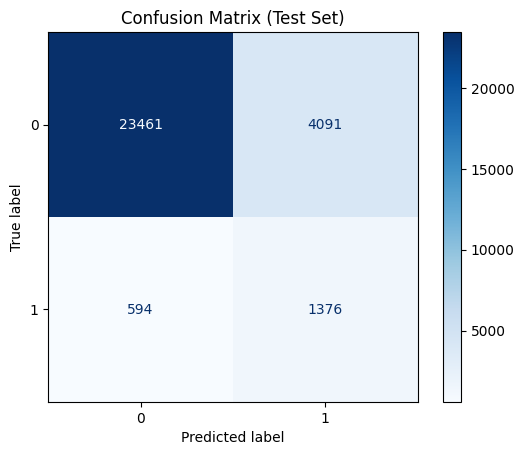

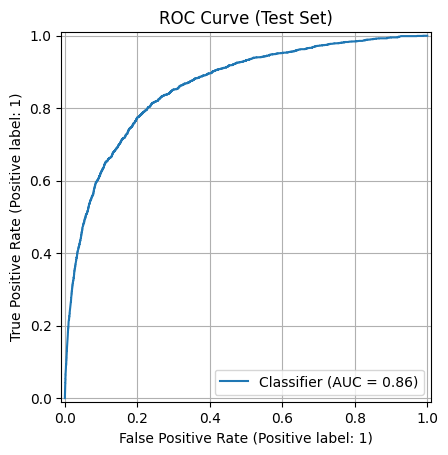

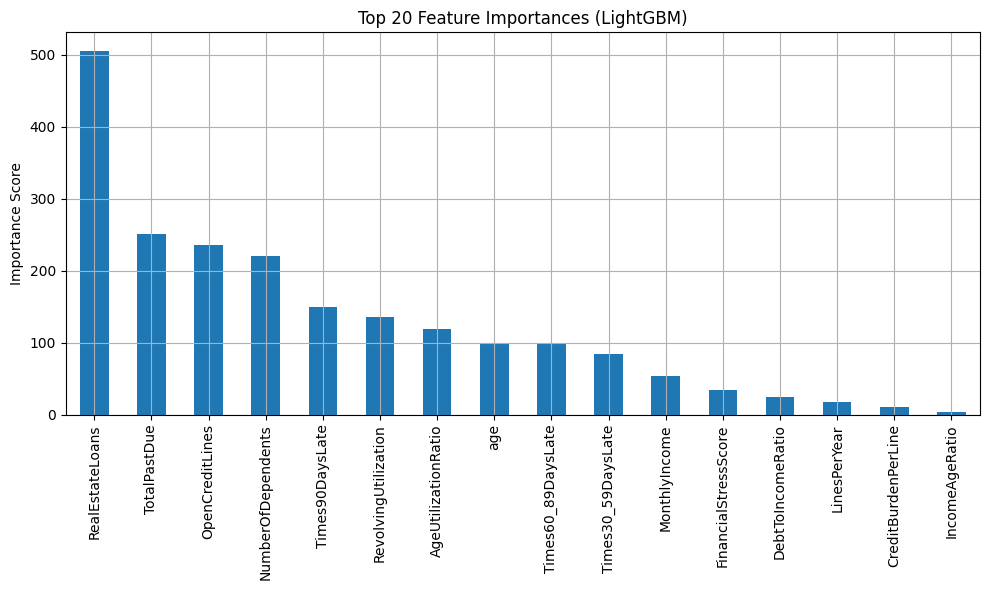

In [66]:
# Predict probabilities on the test set
y_test_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Apply the selected threshold
y_test_pred = (y_test_prob >= best_threshold).astype(int)

# Calculate metrics
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_prob)

print("📊 Final Evaluation on Test Set")
print(f"Threshold     : {best_threshold}")
print(f"AUC           : {auc:.4f}")
print(f"Accuracy      : {acc:.4f}")
print(f"Precision     : {prec:.4f}")
print(f"Recall        : {rec:.4f}")
print(f"F1 Score      : {f1:.4f}")

# Step 4: Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.show()

# Step 5: Plot ROC curve
RocCurveDisplay.from_predictions(y_test, y_test_prob)
plt.title("ROC Curve (Test Set)")
plt.grid(True)
plt.show()

#Feature Importance
importances = best_model.feature_importances_
feature_names = X_test.columns  # Asegúrate de que sea un DataFrame
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_imp.head(20).plot(kind='bar')
plt.title("Top 20 Feature Importances (LightGBM)")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.grid(True)
plt.show()


100%|===================| 117576/118088 [02:56<00:00]        

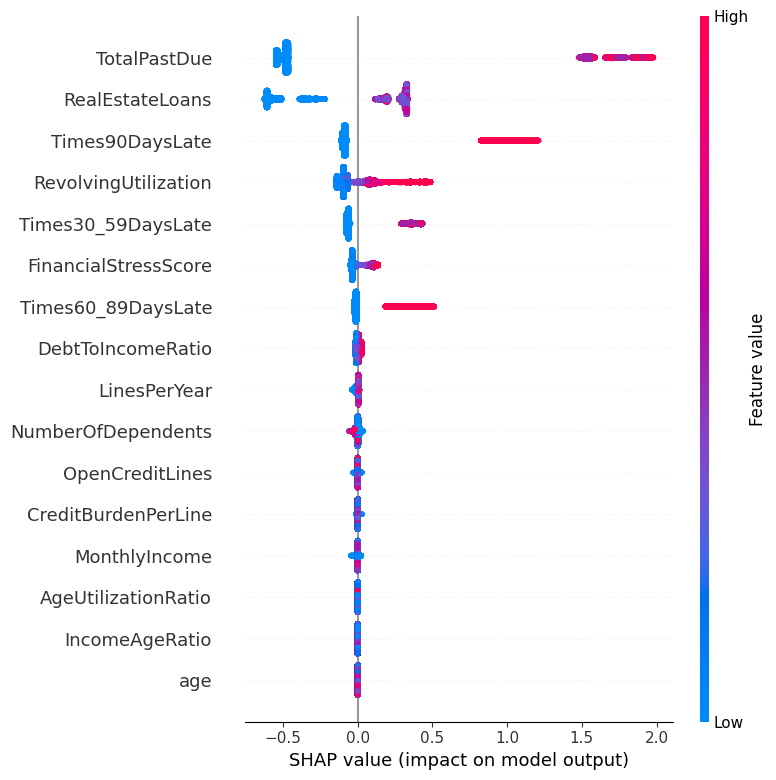

In [73]:
import shap

# Crear el explainer sin check_additivity
explainer = shap.TreeExplainer(best_model, X_train)

# Calcular los SHAP values desactivando el chequeo
shap_values = explainer.shap_values(X_train, check_additivity=False)

# Mostrar el summary plot
shap.summary_plot(shap_values, X_train)


## Results

The final LightGBM model was evaluated on the held-out test set using a custom decision threshold of **0.32**, optimized to prioritize **recall** while maintaining reasonable **precision**. This choice was guided by the business goal of proactively identifying individuals at risk of experiencing financial distress within the next two years.


The **Give Me Some Credit** competition aims to predict financial distress, a task where **recall is more valuable than precision**. In real-world applications, failing to identify someone at risk of default can lead to significant financial losses. On the other hand, incorrectly flagging a customer who is not actually at risk (false positive) may lead to unnecessary interventions but is far less damaging.

- The model achieves a **recall of 70.7%**, correctly identifying the majority of customers who are likely to default.  
- Precision is **24.4%**, meaning that about 1 in 4 flagged customers will actually default. While not ideal, this level of precision is acceptable when the **cost of false negatives outweighs the cost of false positives**.
- An **AUC of 0.86** confirms that the model is capable of distinguishing high-risk customers from low-risk ones across various thresholds.

## 8. Credit Score Transformation 🔢

To make model predictions more interpretable for end users, the predicted probabilities were transformed into a **credit score scale (300–900)**, similar to traditional credit scoring systems.

- **High probabilities of default** are mapped to **lower scores**
- **Low probabilities** are mapped to **higher scores**
- This transformation is independent of the decision threshold used for performance evaluation (0.32)

A score category was also assigned based on the following ranges:

- **Excellent:** 750–900  
- **Good:** 700–749  
- **Fair:** 650–699  
- **Poor:** 600–649  
- **Very Poor:** 300–599

These categories help contextualize risk levels for users and support the decision-making process.


In [82]:
# 1. Función para transformar probabilidad en score (inversamente proporcional)
def probability_to_score(p, min_score=300, max_score=900):
    return round(max_score - (p * (max_score - min_score)))

# 2. Generar los scores a partir de las probabilidades del test set
scores = [probability_to_score(p) for p in y_test_prob]

# 3. Función opcional para clasificar los scores
def score_category(score):
    if score >= 750:
        return "Excellent"
    elif score >= 700:
        return "Good"
    elif score >= 650:
        return "Fair"
    elif score >= 600:
        return "Poor"
    else:
        return "Very Poor"

# 4. Asignar categoría a cada score
categories = [score_category(s) for s in scores]


score_df.head(10)


,Probability of Default,Simulated Score,Risk Category
0,0.728870,463,Very Poor
1,0.144562,813,Excellent
2,0.212134,773,Excellent
3,0.116843,830,Excellent
4,0.123748,826,Excellent
5,0.154242,807,Excellent
6,0.075577,855,Excellent
7,0.071682,857,Excellent
8,0.081015,851,Excellent
9,0.108269,835,Excellent


In [83]:
score_df["Risk Category"].value_counts()

Risk Category
Excellent    22131
Very Poor     2927
Good          2159
Fair          1456
Poor           849
Name: count, dtype: int64

After mapping probabilities to credit scores and assigning categories, we analyzed the distribution of users across risk levels:

| Risk Category | Count   |
|---------------|---------|
| Excellent     | 22,131  |
| Very Poor     | 2,927   |
| Good          | 2,159   |
| Fair          | 1,456   |
| Poor          |   849   |

This distribution confirms that most users in the test set are considered low-risk (Excellent), while a smaller subset falls into higher-risk categories. This insight can help prioritize interventions based on user segments.


## 9. Model Export and Deployment Preparation 💾

To deploy the model and make it accessible in a web application, the following components were saved using `joblib`:

- ✅ **Trained LightGBM model** (`best_model.pkl`)
- ✅ **Scaler object** used during preprocessing (`scaler.pkl`)
- ✅ **List of feature names** used in training (`features.pkl`)

These files were saved to a `model/` directory and are ready to be loaded by the Streamlit app for real-time predictions.


In [37]:
import joblib
import os

os.makedirs("../model", exist_ok=True)

joblib.dump(best_model, "../model/best_model.pkl")
joblib.dump(scaler, "../model/scaler.pkl")
joblib.dump(X_train.columns.tolist(), "../model/features.pkl")

['../model/features.pkl']

## 10. Streamlit App: Credit Score Simulator 💻

To make the model accessible and interpretable for users, an interactive web app was developed using **Streamlit**.

The app allows users to input financial and demographic data to simulate their credit score and risk category in real-time. It leverages the trained LightGBM model and applies consistent preprocessing and feature engineering.

### 🔧 Key Features:

- **Model Loading**: Loads the trained LightGBM model, scaler, and feature list from disk.
- **User Inputs**: Interactive sliders and number inputs allow users to enter:
  - Age
  - Monthly Income
  - Debt-to-Income Ratio
  - Credit utilization
  - Credit lines, loans, late payments, and dependents
- **Feature Engineering**: Automatically computes derived features such as:
  - Total past due events  
  - Financial stress indicators  
  - Ratios related to age, income, and credit lines  
- **Prediction**:
  - Predicts probability of default  
  - Transforms it into a **credit score (300–900)**  
  - Categorizes it into 5 risk levels (Poor → Excellent)  
- **Visualization**:
  - Displays a dynamic **speedometer-style chart** using Matplotlib to show the score
  - Shows the estimated probability of default
- **Recommendations**:
  - Provides general tips based on the user's risk category 

This tool serves as a practical simulation of how credit decisions can be supported using machine learning and helps users understand which factors influence their credit score.


## 11. Conclusions & Next Steps 🧾

### ✅ Conclusions

This project successfully developed an end-to-end credit risk prediction system using real-world financial data:

- Multiple classification models were trained and evaluated, with **LightGBM** emerging as the top performer based on **AUC** and **F1-score**.
- **Class imbalance** was addressed using **SMOTE** in cross-validation folds to ensure a fair evaluation of minority cases.
- **Optuna** was used for hyperparameter tuning, improving model performance through a systematic exploration of parameters over 100 trials.
- A **custom decision threshold (0.32)** was applied to optimize for **recall**, aligning with the business goal of minimizing false negatives in default detection.
- Model predictions were transformed into a **credit score scale (300–900)** and categorized into intuitive labels (e.g., *Fair*, *Excellent*) for better interpretability.
- A fully functional **Streamlit app** was built to allow users to input personal and financial data, receive a real-time credit score, risk category, and a personalized recommendation — all supported by a visual **speedometer-style chart**.

Overall, the project combines robust modeling, interpretability, and usability, creating a solid foundation for credit risk simulation and user engagement.

---

### 🚀 Next Steps

To further improve and extend the project:

- **Feature Importance & Explainability**: Incorporate tools like **SHAP** to explain predictions and increase transparency in risk assessment.
- **Model Generalization**: Validate the model on external datasets or with time-based validation to ensure robustness over time.
- **Expanded Input Features**: Include additional features such as spending behavior, employment status, or credit history depth to enhance prediction power.
- **Threshold Optimization by Segment**: Consider dynamic thresholds for different user segments (e.g., income levels or age groups).
- **Monitoring & Feedback Loop**: Track model performance post-deployment and build a retraining pipeline as new data becomes available.
- **Secure Deployment**: Host the Streamlit app with proper user authentication, encryption, and logging mechanisms for production use.

